In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import sys

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

from src.data_analysis.data_analysis import fetch_historical_data
from src.modeling.statistical_methods import (
    MachineLearningPipeline,
    feature_importance_mdi,
    feature_importance_mda,
    feature_importance_sfi,
    feature_importance_orthogonal,
    weighted_kendalls_tau
)
from src.modeling import PurgedKFold
from src.modeling.chronos_feature_pipeline import ChronosFeaturePipeline
from src.constants import VOLUME_COL, CLOSE_COL

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final


In [24]:
def plot_importance(importance_series, title, color="skyblue"):
    """
    Helper function to plot feature importance.
    """
    if importance_series.empty:
        print(f"No positive importance found for {title}")
        return
        
    plt.figure(figsize=(15, 6))
    importance_series.head(20).plot(kind='bar', color=color)
    plt.title(title)
    plt.ylabel("Importance")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(data_dict, title):
    """
    Helper function to compute and plot a pairwise Weighted Kendall's Tau heatmap.
    
    Args:
        data_dict (dict): Dictionary where keys are names and values are pd.Series of importance scores.
        title (str): Title for the heatmap.
    """
    # Create a DataFrame from the series, aligning indices (inner join)
    df = pd.DataFrame(data_dict).dropna()
    
    if df.empty:
        print(f"No overlapping features found for correlation heatmap: {title}")
        return

    cols = df.columns
    n = len(cols)
    corr_matrix = np.zeros((n, n))
    
    print(f"\nComputing Weighted Kendall's Tau Correlation Matrix for: {list(cols)}")
    
    for i in range(n):
        for j in range(n):
            if i == j:
                corr_matrix[i, j] = 1.0
            else:
                # weighted_kendalls_tau handles alignment internally, but we already aligned in df
                tau, _ = weighted_kendalls_tau(df.iloc[:, i], df.iloc[:, j])
                corr_matrix[i, j] = tau
                
    corr_df = pd.DataFrame(corr_matrix, index=cols, columns=cols)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_original_features(features, y, cv, sample_weights, t1, model_params):
    """
    Computes and plots MDI, MDA, and SFI for original features.
    """
    print("\n--- Analyzing Original Features ---")
    
    # Align features with target
    X = features.loc[y.index]
    
    # 1. MDI (Requires fitting a model on original features)
    print("Computing MDI for Original Features...")
    model = RandomForestClassifier(**model_params)
    model.fit(X, y, sample_weight=sample_weights)
    mdi = feature_importance_mdi(model, X, y)
    plot_importance(mdi, "Original Features - MDI", "skyblue")
    
    # 2. MDA
    print("Computing MDA for Original Features...")
    model_mda = RandomForestClassifier(**model_params)
    mda = feature_importance_mda(model_mda, X, y, cv, sample_weights, t1)
    # Invert log-loss: we want (Loss_perm - Loss_orig)
    mda = -mda 
    
    # Filter for plotting (positive only) but keep raw for correlation analysis
    plot_mda = mda.drop('full_model', errors='ignore')
    plot_mda = plot_mda[plot_mda > 0].sort_values(ascending=False)
    plot_importance(plot_mda, "Original Features - MDA", "salmon")
    
    # 3. SFI
    print("Computing SFI for Original Features...")
    model_sfi = RandomForestClassifier(**model_params)
    sfi = feature_importance_sfi(model_sfi, X, y, cv, sample_weights, t1)
    plot_importance(sfi.sort_values(ascending=False), "Original Features - SFI", "lightgreen")
    
    # 4. Correlation Heatmap
    # Use raw scores (including negatives) for correlation to capture the full relationship
    mda_clean = mda.drop('full_model', errors='ignore')
    
    plot_correlation_heatmap(
        {
            "MDI": mdi,
            "MDA": mda_clean,
            "SFI": sfi
        },
        "Correlation of Feature Importance Metrics (Original Features)"
    )
    
    return mdi, mda, sfi


def plot_chronos_features(features, y, cv, sample_weights, t1, model_params):
    """
    Computes and plots MDI, MDA, and SFI for Chronos+tabular features.
    """
    print("\n--- Analyzing Chronos + Tabular Features ---")

    # Align features with target and handle potential NaNs from feature engineering
    common_index = features.index.intersection(y.index).intersection(sample_weights.index)
    X = features.loc[common_index]
    y_aligned = y.loc[common_index]
    sample_weights_aligned = sample_weights.loc[common_index]
    t1_aligned = t1.loc[y_aligned.index] if isinstance(t1, pd.Series) else t1


    # 1. MDI
    print("Computing MDI for Chronos Features...")
    model = RandomForestClassifier(**model_params)
    model.fit(X, y_aligned, sample_weight=sample_weights_aligned)
    mdi = feature_importance_mdi(model, X, y_aligned)
    plot_importance(mdi, "Chronos Features - MDI", "skyblue")

    # 2. MDA
    print("Computing MDA for Chronos Features...")
    model_mda = RandomForestClassifier(**model_params)
    mda = feature_importance_mda(model_mda, X, y_aligned, cv, sample_weights_aligned, t1_aligned)
    # Invert log-loss: we want (Loss_perm - Loss_orig)
    mda = -mda

    # Filter for plotting (positive only) but keep raw for correlation analysis
    plot_mda = mda.drop('full_model', errors='ignore')
    plot_mda = plot_mda[plot_mda > 0].sort_values(ascending=False)
    plot_importance(plot_mda, "Chronos Features - MDA", "salmon")

    # 3. SFI
    print("Computing SFI for Chronos Features...")
    model_sfi = RandomForestClassifier(**model_params)
    sfi = feature_importance_sfi(model_sfi, X, y_aligned, cv, sample_weights_aligned, t1_aligned)
    plot_importance(sfi.sort_values(ascending=False), "Chronos Features - SFI", "lightgreen")

    # 4. Correlation Heatmap
    # Use raw scores (including negatives) for correlation to capture the full relationship
    mda_clean = mda.drop('full_model', errors='ignore')

    plot_correlation_heatmap(
        {
            "MDI": mdi,
            "MDA": mda_clean,
            "SFI": sfi
        },
        "Correlation of Feature Importance Metrics (Chronos Features)"
    )

    return mdi, mda, sfi


def plot_pca_features(X_pca, y, cv, sample_weights, t1, trained_model):
    """
    Computes and plots MDI, MDA, and SFI for PCA features.
    """
    print("\n--- Analyzing PCA Features ---")
    
    # 1. MDI (Use trained_model which is already fitted on X_pca)
    print("Computing MDI for PCA Features...")
    mdi = feature_importance_mdi(trained_model, X_pca, y)
    plot_importance(mdi, "PCA Features - MDI", "skyblue")
    
    # 2. MDA
    print("Computing MDA for PCA Features...")
    # Use clone to ensure fresh model for MDA CV
    mda = feature_importance_mda(clone(trained_model), X_pca, y, cv, sample_weights, t1)
    mda = -mda
    
    # Filter for plotting
    plot_mda = mda.drop('full_model', errors='ignore')
    plot_mda = plot_mda[plot_mda > 0].sort_values(ascending=False)
    plot_importance(plot_mda, "PCA Features - MDA", "salmon")
    
    # 3. SFI (Run on PCA features)
    print("Computing SFI for PCA Features...")
    sfi = feature_importance_sfi(trained_model, X_pca, y, cv, sample_weights, t1)
    plot_importance(sfi.sort_values(ascending=False), "PCA Features - SFI", "lightgreen")
    
    return mdi, mda, sfi


def compare_pca_importance(mdi_ortho, mda_ortho, sfi_ortho, pca, X_pca):
    """
    Computes Weighted Kendall's Tau for MDI, MDA, SFI vs PCA Explained Variance.
    """
    print("\n--- Comparing ML Importance vs PCA Explained Variance ---")
    
    explained_variance = pd.Series(
        pca.explained_variance_ratio_, index=X_pca.columns, name="Explained Variance"
    )
    
    # Drop full_model from MDA if present
    mda_clean = mda_ortho.drop('full_model', errors='ignore') if isinstance(mda_ortho, pd.Series) else mda_ortho
    
    # Plot Correlation Heatmap including Explained Variance
    plot_correlation_heatmap(
        {
            "MDI (Ortho)": mdi_ortho,
            "MDA (Ortho)": mda_clean,
            "SFI (Ortho)": sfi_ortho,
            "PCA Var": explained_variance
        },
        "Correlation of ML Importance vs PCA Variance"
    )
    
    # Plot Comparison for MDI (Standard Orthogonal Importance)
    results = pd.concat([mdi_ortho.rename("Orthogonal Importance"), explained_variance], axis=1)
    results = results.sort_values(by="Orthogonal Importance", ascending=False)
    
    fig, ax1 = plt.subplots(figsize=(15, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('MDI Importance', color=color)
    ax1.bar(results.index[:20], results["Orthogonal Importance"][:20], color=color, alpha=0.6, label='MDI Importance')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.xticks(rotation=45, ha='right')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Explained Variance', color=color)
    ax2.plot(results.index[:20], results["Explained Variance"][:20], color=color, marker='o', label='Explained Variance')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("MDI Importance vs Explained Variance (Top 20 PCs)")
    fig.tight_layout()
    plt.show()

In [25]:
# --- Configuration ---
config = {
    "dollar_threshold": 1e9,
    "horizon": 5,
    "pt": 1,
    "sl": 1,
    "min_ret": 0.0005,
    "n_splits": 3,
    "pct_embargo": 0.01,
    "feature_whitelist": None,
    "pca_whitelist": None
}

# --- Data Loading ---
data_path = os.path.join(project_root, "data/binance/python/data/spot/daily/klines/BTCUSDT/1h/BTCUSDT_consolidated_klines.csv")

raw_tick_data = fetch_historical_data(
    symbol="BTC/USDT",
    timeframe="1h",
    start_date="2020-01-01T00:00:00Z",
    end_date="2025-08-01T00:00:00Z",
    data_path=data_path,
)
raw_tick_data.index = pd.to_datetime(raw_tick_data.index)
raw_tick_data.rename(columns={VOLUME_COL: "volume", CLOSE_COL: "close"}, inplace=True)

print(f"Data loaded: {raw_tick_data.shape}")

Data loaded: (48905, 12)


In [128]:
# --- Pipeline Execution ---
model_params = {"n_estimators": 100, "random_state": 42, "n_jobs": -1}

print("Running ML Pipeline with base parameters... (This may take a few minutes)")
pipeline = MachineLearningPipeline(config)
model = RandomForestClassifier(**model_params)

# Manually run first steps to get original features, as run_cv doesn't return them
bars = pipeline.step_1_data_structuring(raw_tick_data)
features = pipeline.step_2_feature_engineering(bars)

# Now, call the main CV runner which handles scaling, PCA, and training
# Note: y returned by run_cv is already aligned with X, sample_weights, and t1
trained_model, scores, X, y, sample_weights, t1, pca = pipeline.run_cv(raw_tick_data, model)

print(f"\nCross-validation F1 Scores: {scores}")
print(f"Average F1 Score: {np.mean(scores):.4f}")

Running ML Pipeline... (This may take a few minutes)

>>> Function 'step_1_data_structuring' executed in 1.5247 seconds

>>> Function 'frac_diff_ffd' executed in 4.6640 seconds

>>> Function 'frac_diff_ffd' executed in 0.6587 seconds

>>> Function 'frac_diff_ffd' executed in 1.3717 seconds

>>> Function 'frac_diff_ffd' executed in 2.4812 seconds

>>> Function 'frac_diff_ffd' executed in 3.3157 seconds

>>> Function 'find_minimum_d' executed in 15.4442 seconds
minimum d: 0.4

>>> Function 'step_2_feature_engineering' executed in 15.5618 seconds

>>> Function 'step_3_labeling_and_weighting' executed in 5.1472 seconds

>>> Function 'orthogonalize_pca' executed in 0.0086 seconds

>>> Function 'machine_learning_cycle' executed in 23.2505 seconds

Cross-validation F1 Scores: [0.39601483726283543, 0.3991448159040129, 0.341391089581269]
Average F1 Score: 0.3789



--- Analyzing Original Features ---
Computing MDI for Original Features...

>>> Function 'feature_importance_mdi' executed in 0.1910 seconds


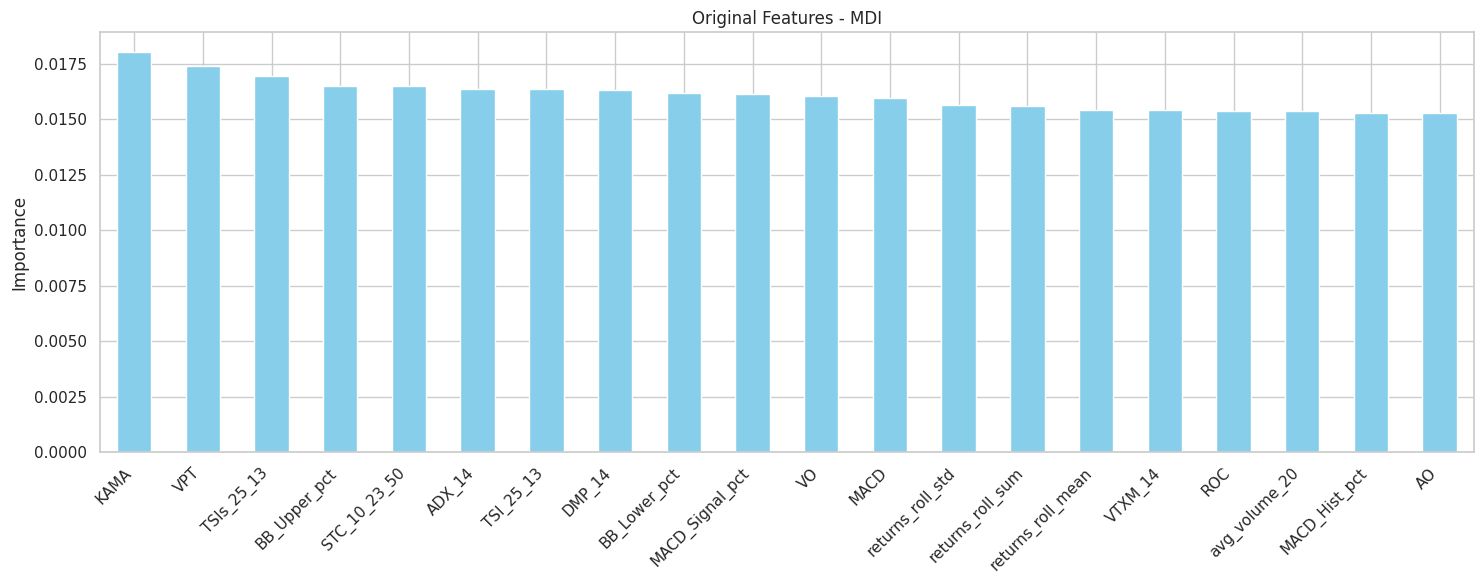

Computing MDA for Original Features...

>>> Function 'feature_importance_mda' executed in 7.2070 seconds


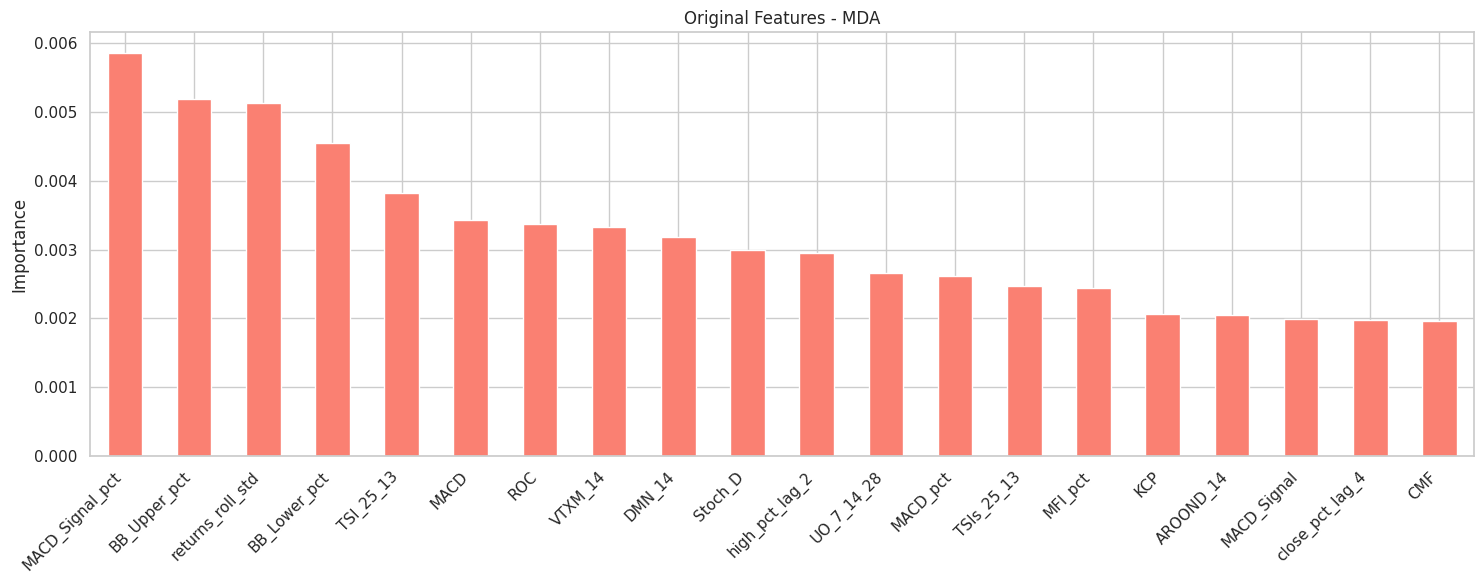

Computing SFI for Original Features...

>>> Function 'feature_importance_sfi' executed in 40.8995 seconds


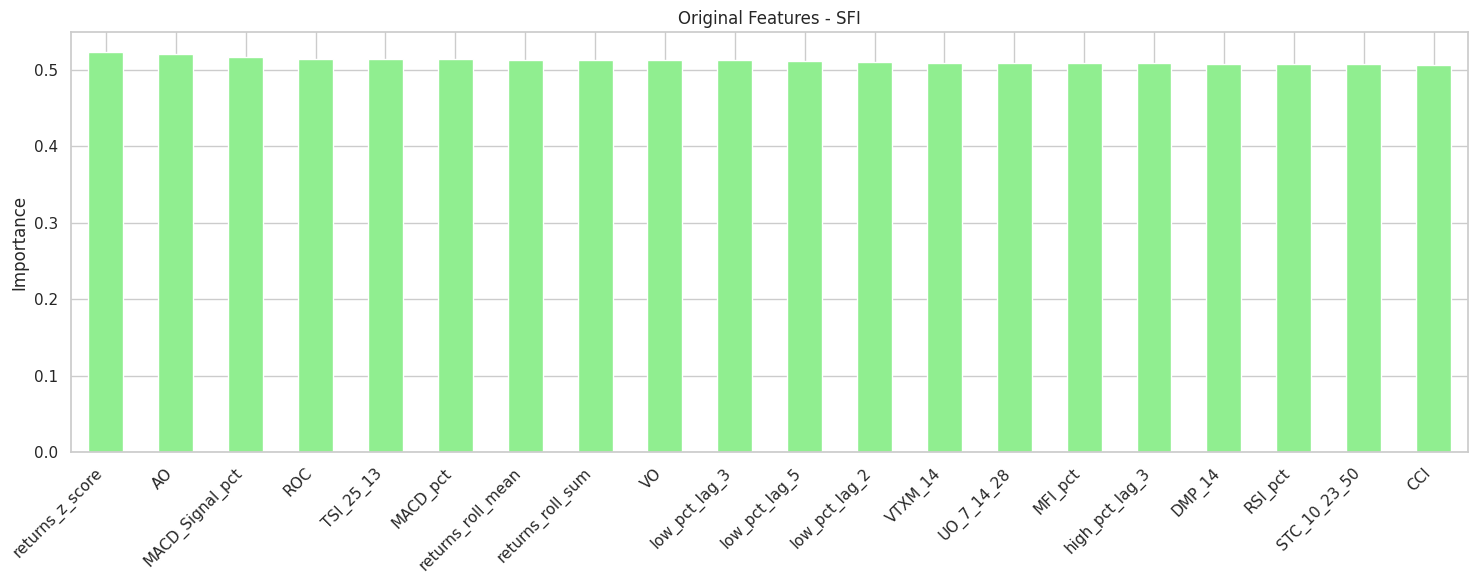


Computing Weighted Kendall's Tau Correlation Matrix for: ['MDI', 'MDA', 'SFI']


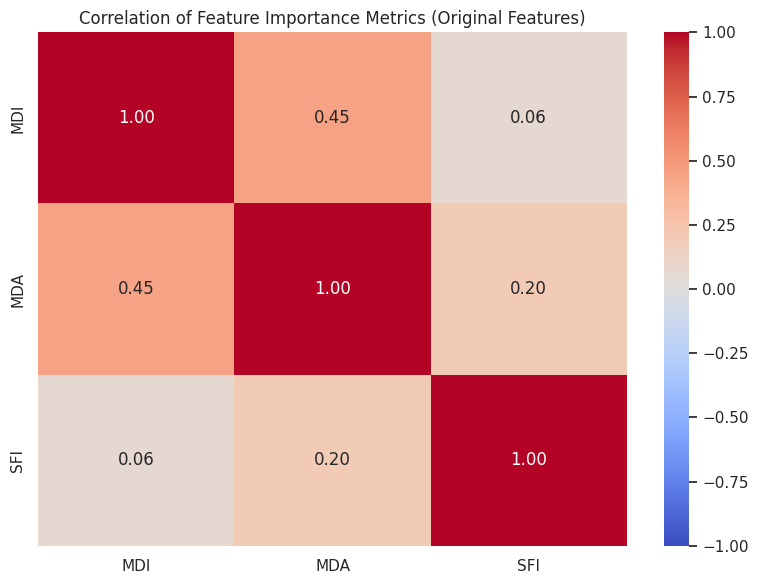


--- Analyzing PCA Features ---
Computing MDI for PCA Features...

>>> Function 'feature_importance_mdi' executed in 0.1905 seconds


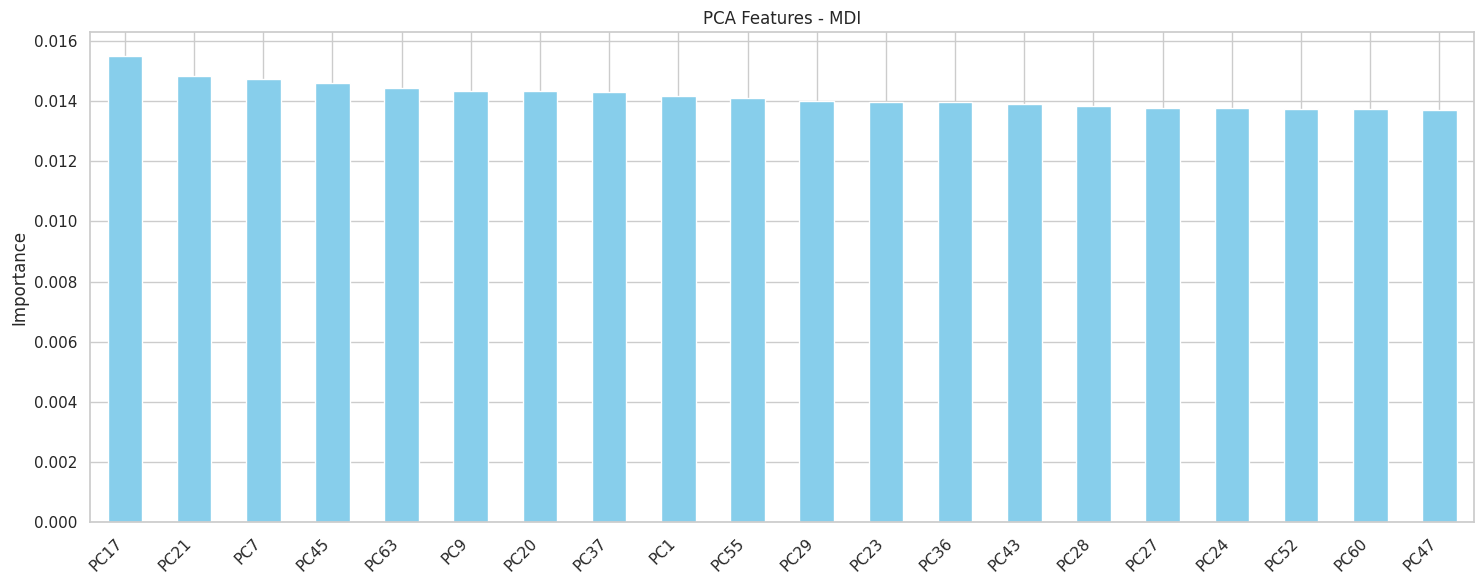

Computing MDA for PCA Features...

>>> Function 'feature_importance_mda' executed in 7.1984 seconds


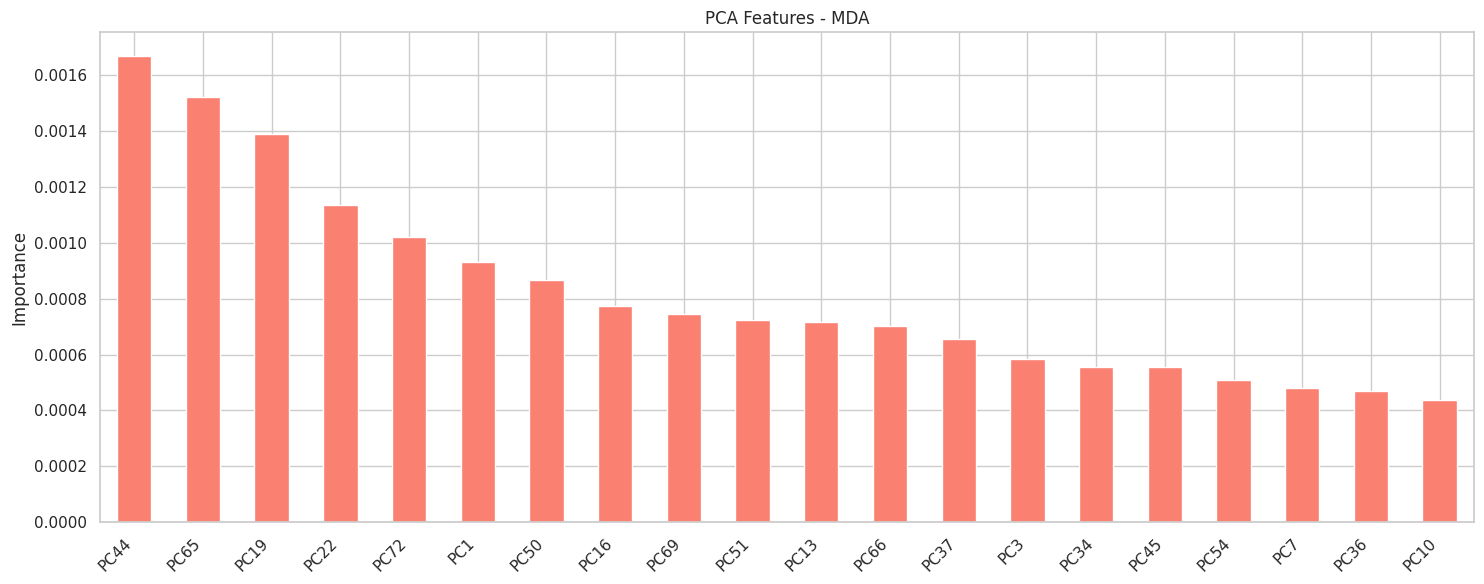

Computing SFI for PCA Features...

>>> Function 'feature_importance_sfi' executed in 39.7435 seconds


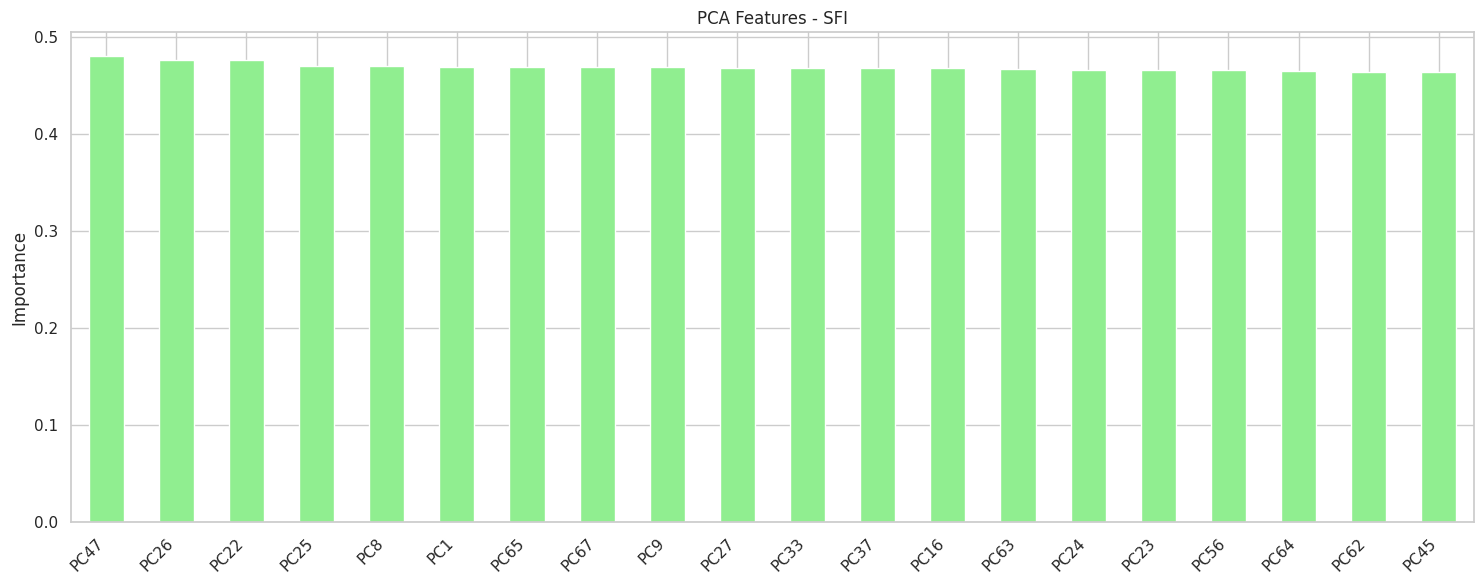


--- Comparing ML Importance vs PCA Explained Variance ---

Computing Weighted Kendall's Tau Correlation Matrix for: ['MDI (Ortho)', 'MDA (Ortho)', 'SFI (Ortho)', 'PCA Var']


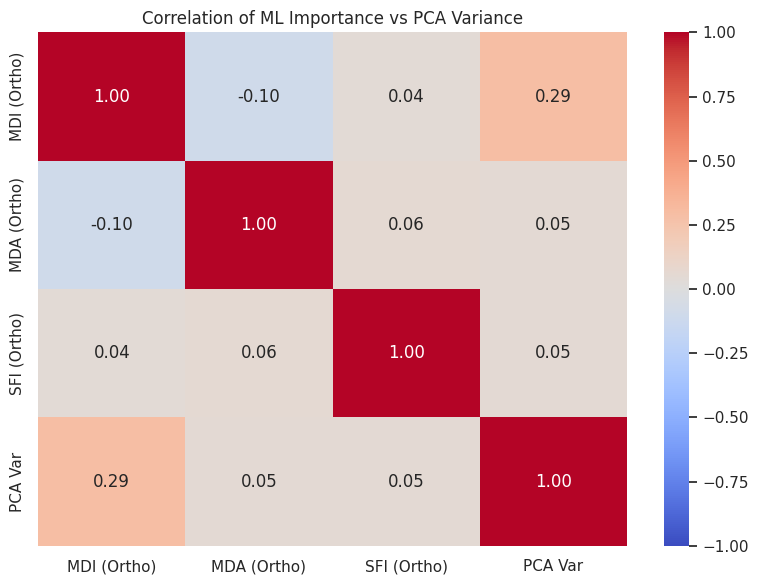

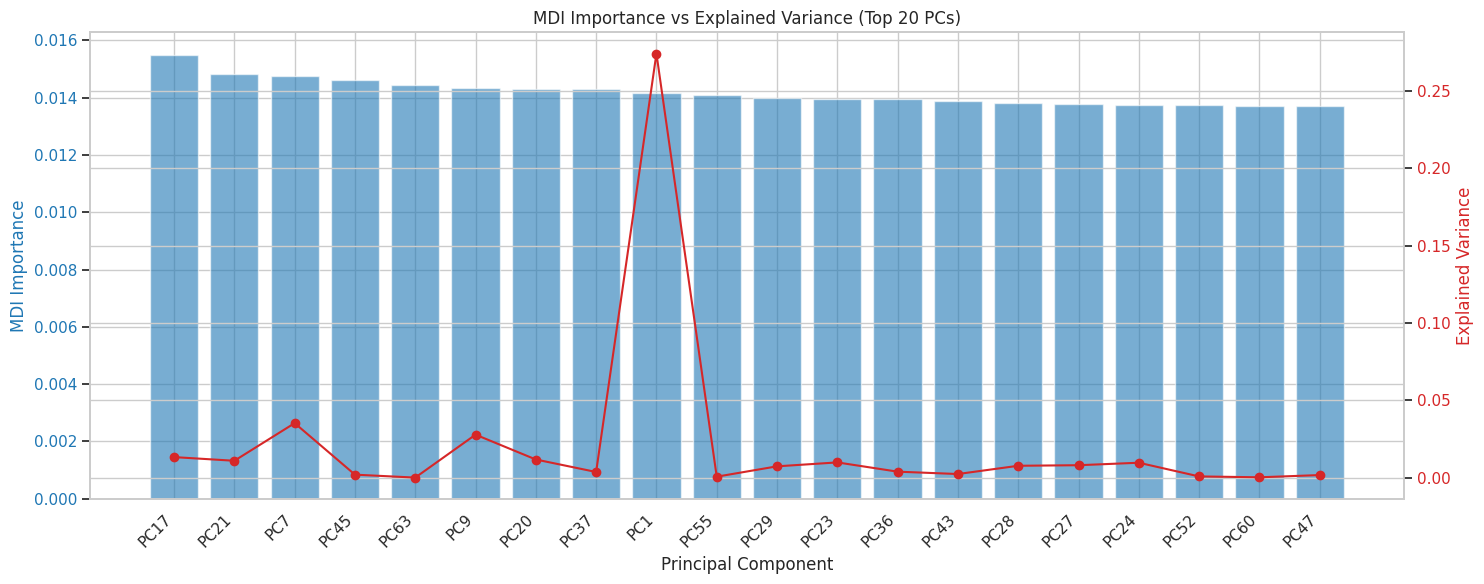

In [129]:
# Define CV for feature importance
cv = PurgedKFold(
    n_splits=config["n_splits"],
    t1=t1,
    pct_embargo=config["pct_embargo"],
)

# 1. Analyze Original Features
mdi_orig, mda_orig, sfi_orig = plot_original_features(
    features, y, cv, sample_weights, t1, model_params
)

# 2. Analyze PCA Features
mdi_ortho, mda_ortho, sfi_ortho = plot_pca_features(
    X, y, cv, sample_weights, t1, trained_model
)

# 3. Compare PCA Importance
compare_pca_importance(mdi_ortho, mda_ortho, sfi_ortho, pca, X)

In [133]:
sample_weights.mean()

0.00022742779167614282

In [139]:
# --- Pipeline Execution ---
model_params = {"n_estimators": 1000, "random_state": 42, "n_jobs": -1, "min_samples_leaf": 0.05, "max_features":1}

print("\nRunning ML Pipeline with high-complexity model... (This may take a few minutes)")
# The original features ('features') are the same, so we can reuse them from the previous run.
# The pipeline config is also the same.
model = RandomForestClassifier(**model_params)
trained_model, scores, X, y, sample_weights, t1, pca = pipeline.run_cv(raw_tick_data, model)

print(f"\nCross-validation F1 Scores: {scores}")
print(f"Average F1 Score: {np.mean(scores):.4f}")

Running ML Pipeline... (This may take a few minutes)

>>> Function 'step_1_data_structuring' executed in 1.7216 seconds

>>> Function 'frac_diff_ffd' executed in 4.9664 seconds

>>> Function 'frac_diff_ffd' executed in 0.8120 seconds

>>> Function 'frac_diff_ffd' executed in 1.5255 seconds

>>> Function 'frac_diff_ffd' executed in 2.6476 seconds

>>> Function 'frac_diff_ffd' executed in 3.5887 seconds

>>> Function 'find_minimum_d' executed in 16.9928 seconds
minimum d: 0.4

>>> Function 'step_2_feature_engineering' executed in 17.1336 seconds

>>> Function 'step_3_labeling_and_weighting' executed in 4.9523 seconds

>>> Function 'orthogonalize_pca' executed in 0.0114 seconds

>>> Function 'machine_learning_cycle' executed in 29.7299 seconds

Cross-validation F1 Scores: [0.39727017122884156, 0.30273091526563806, 0.27058705657255144]
Average F1 Score: 0.3235



--- Analyzing Original Features ---
Computing MDI for Original Features...

>>> Function 'feature_importance_mdi' executed in 1.6460 seconds


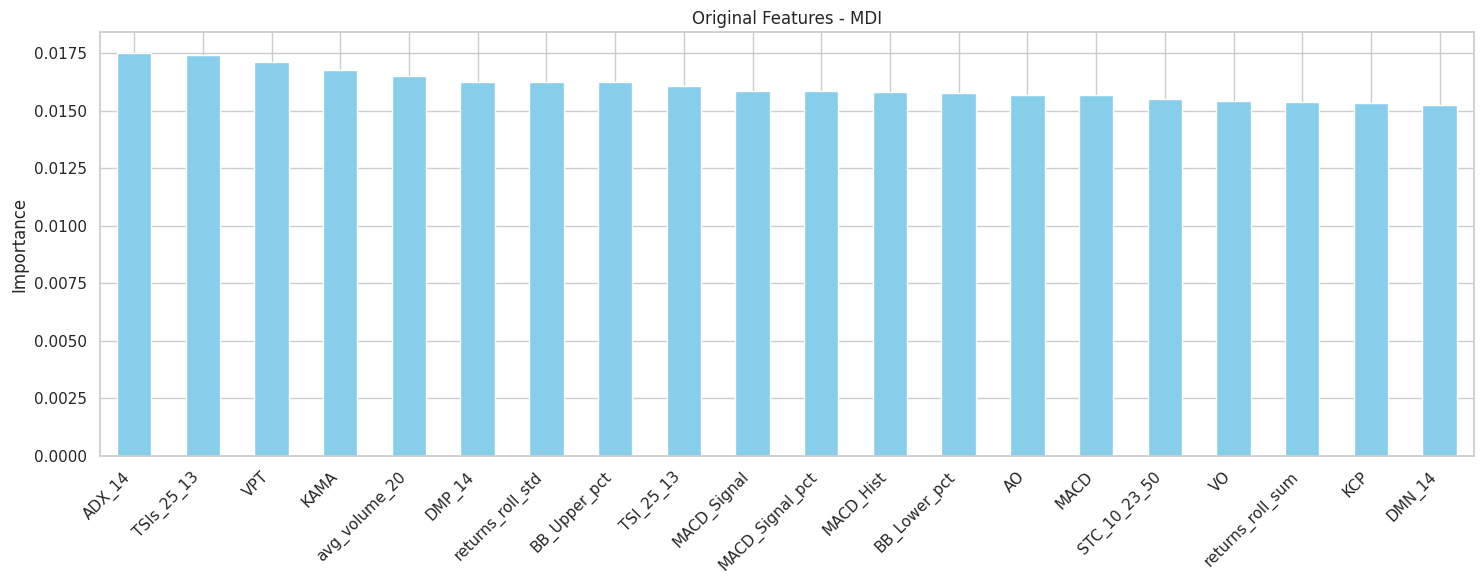

Computing MDA for Original Features...

>>> Function 'feature_importance_mda' executed in 41.2603 seconds


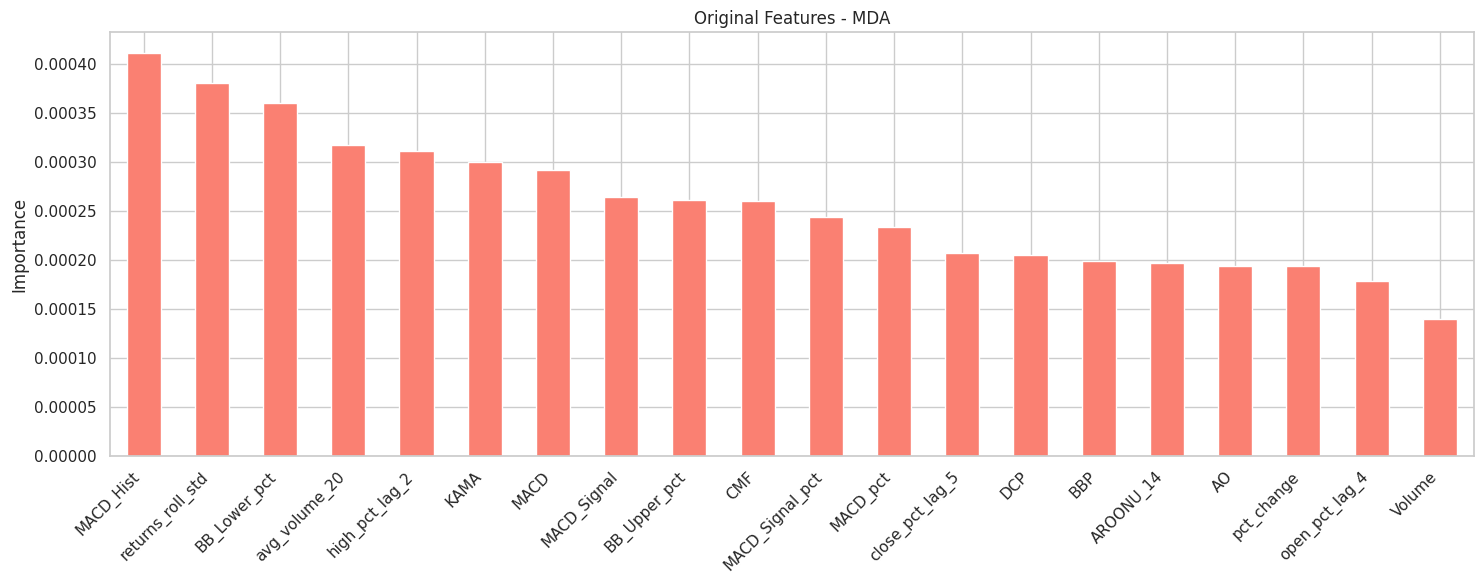

Computing SFI for Original Features...

>>> Function 'feature_importance_sfi' executed in 338.3029 seconds


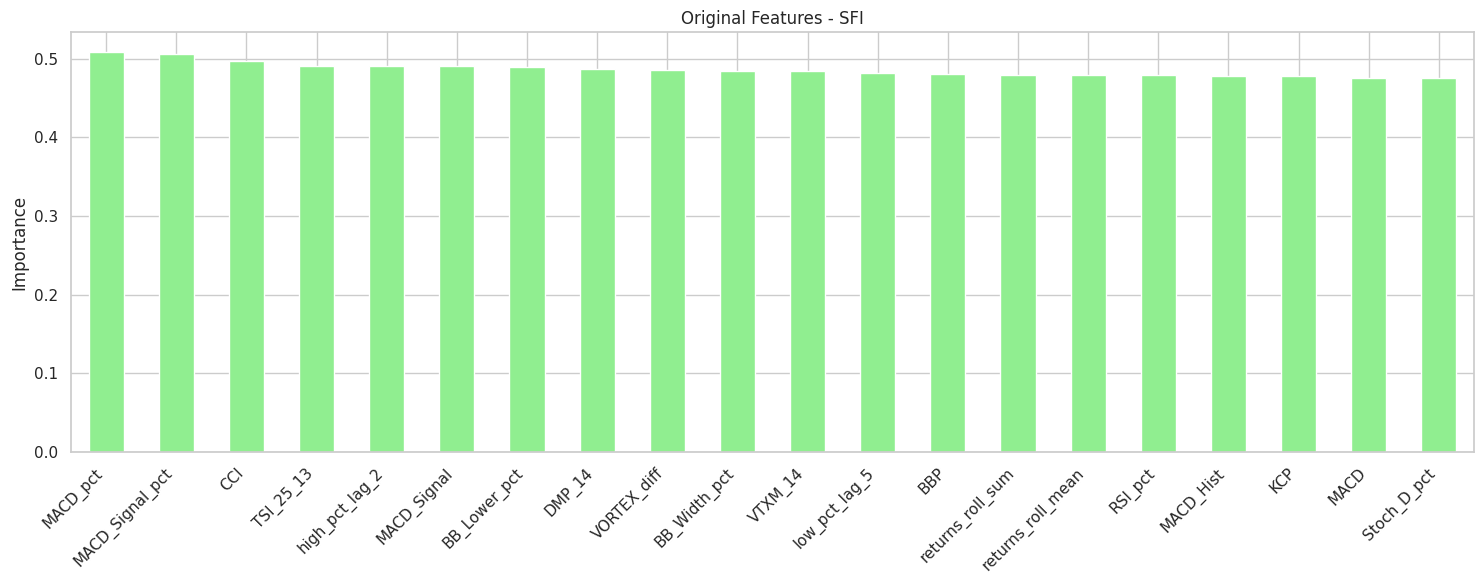


Computing Weighted Kendall's Tau Correlation Matrix for: ['MDI', 'MDA', 'SFI']


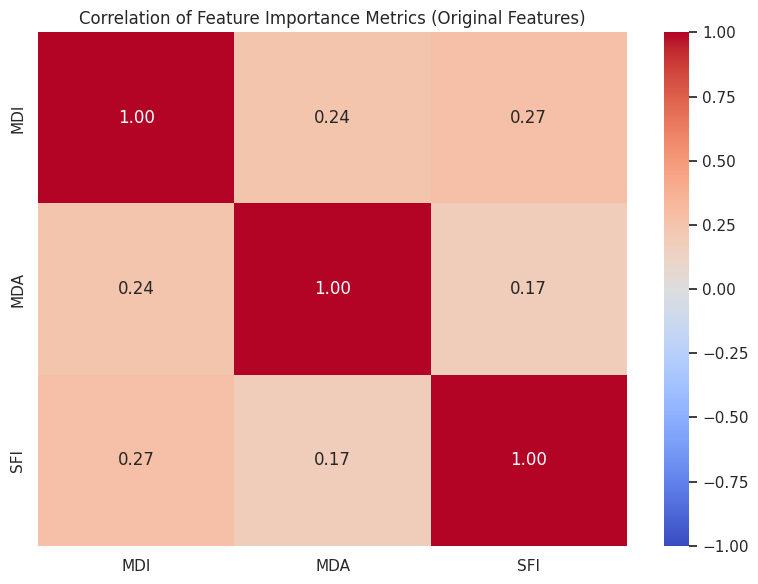


--- Analyzing PCA Features ---
Computing MDI for PCA Features...

>>> Function 'feature_importance_mdi' executed in 1.6203 seconds


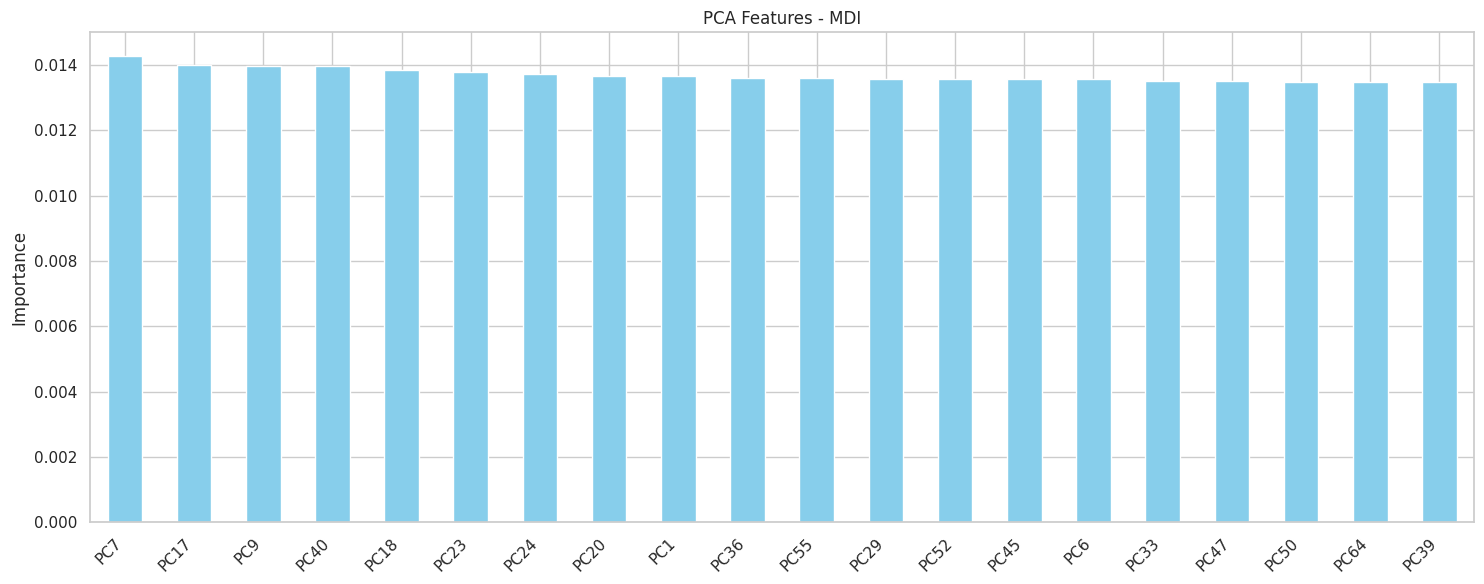

Computing MDA for PCA Features...

>>> Function 'feature_importance_mda' executed in 46.3090 seconds


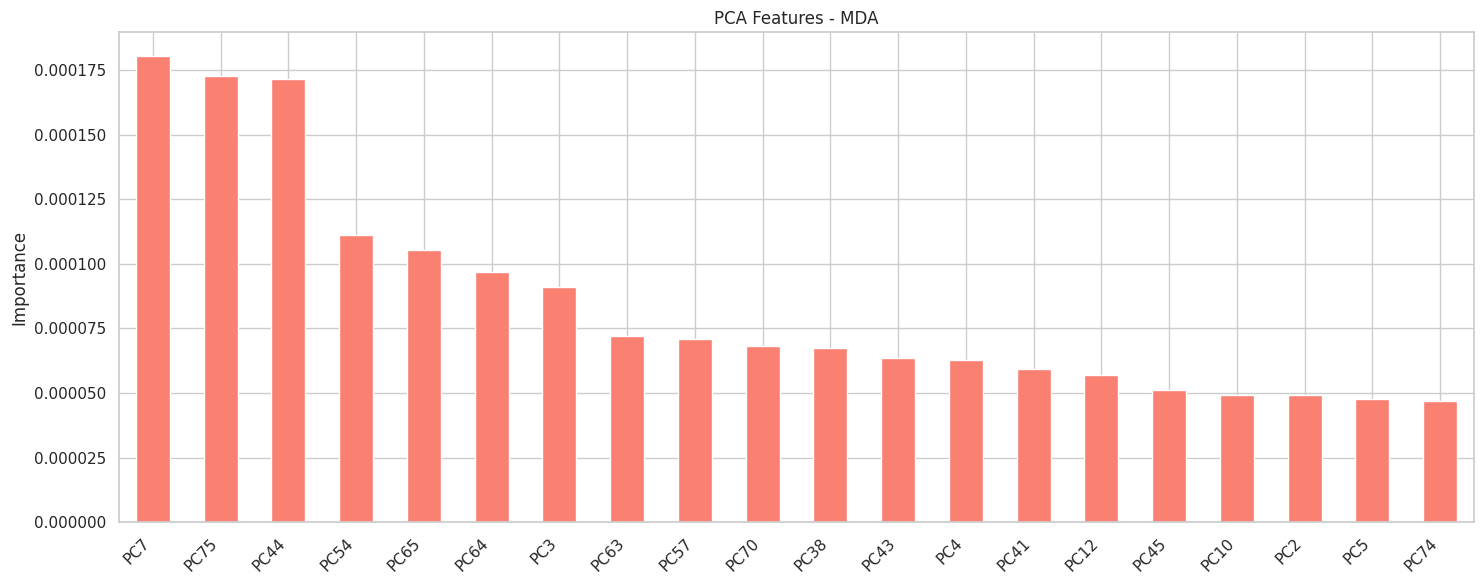

Computing SFI for PCA Features...

>>> Function 'feature_importance_sfi' executed in 337.0202 seconds


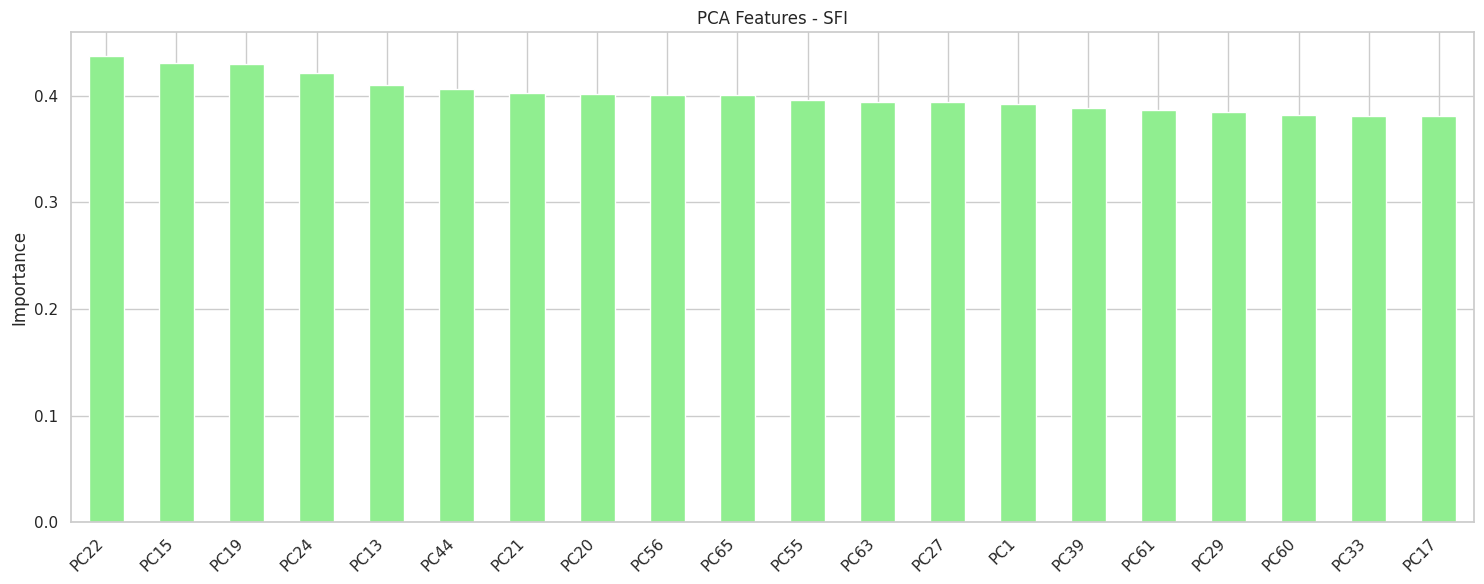


--- Comparing ML Importance vs PCA Explained Variance ---

Computing Weighted Kendall's Tau Correlation Matrix for: ['MDI (Ortho)', 'MDA (Ortho)', 'SFI (Ortho)', 'PCA Var']


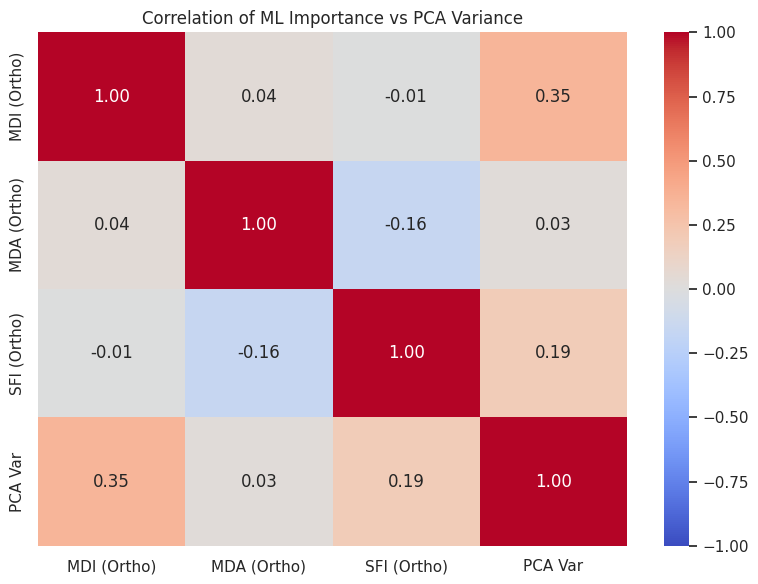

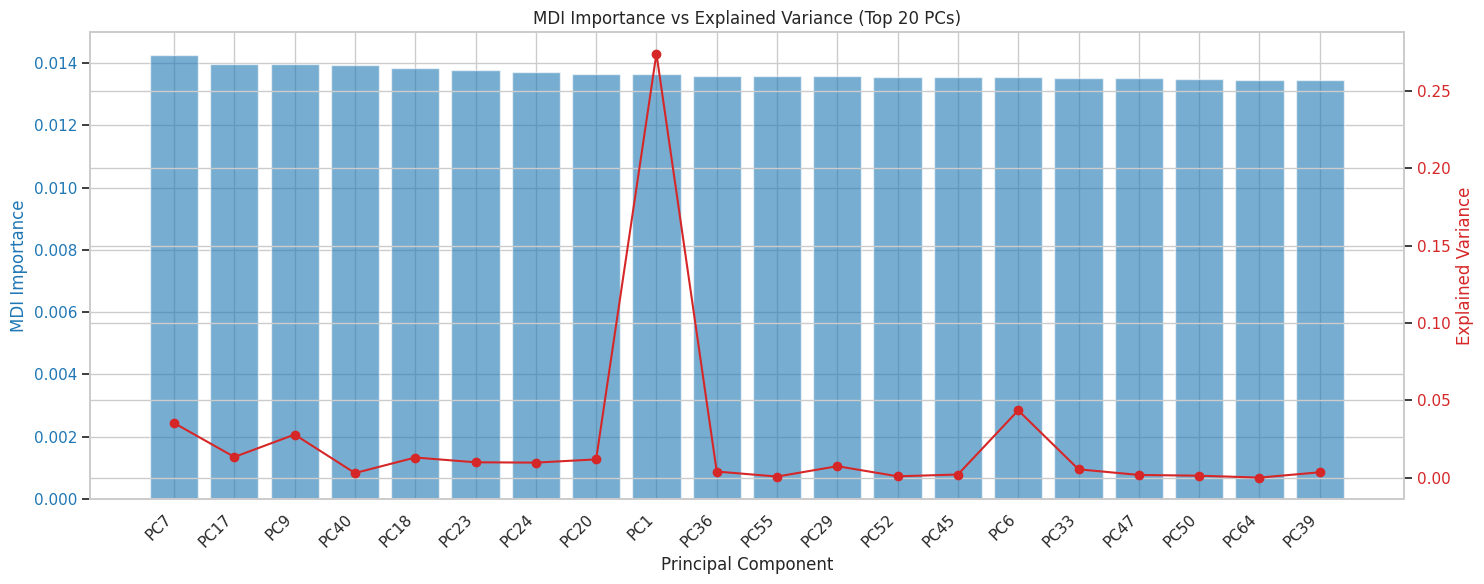

In [140]:
# Define CV for feature importance
cv = PurgedKFold(
    n_splits=config["n_splits"],
    t1=t1,
    pct_embargo=config["pct_embargo"],
)

# 1. Analyze Original Features
mdi_orig, mda_orig, sfi_orig = plot_original_features(
    features, y, cv, sample_weights, t1, model_params
)

# 2. Analyze PCA Features
mdi_ortho, mda_ortho, sfi_ortho = plot_pca_features(
    X, y, cv, sample_weights, t1, trained_model
)

# 3. Compare PCA Importance
compare_pca_importance(mdi_ortho, mda_ortho, sfi_ortho, pca, X)

In [13]:
# --- Pipeline Execution ---
feature_whitelist = ["MACD_Hist", "returns_roll_std", "BB_Lower_pct", "avg_volume_20", "high_pct_lag_2", "KAMA", "MACD",
  "MACD_Signal", "BB_Upper_pct", "CMF", "MACD_Signal_pct", "close_pct_lag_5", "DCP", "BBP", "AROONU_14", "AO",
  "pct_change", "open_pct_lag_4", "Volume"]

config_wl = {
    "dollar_threshold": 1e9,
    "horizon": 5,
    "pt": 1,
    "sl": 1,
    "min_ret": 0.0005,
    "n_splits": 3,
    "pct_embargo": 0.01,
    "feature_whitelist": feature_whitelist,
    "pca_whitelist": None
}

model_params = {"n_estimators": 1000, "random_state": 42, "n_jobs": -1, "min_samples_leaf": 0.05}

print("\nRunning ML Pipeline with feature whitelist... (This may take a few minutes)")
pipeline_wl = MachineLearningPipeline(config_wl)
model = RandomForestClassifier(**model_params)

# Manually get original features with the whitelist applied
bars = pipeline_wl.step_1_data_structuring(raw_tick_data)
features = pipeline_wl.step_2_feature_engineering(bars)

# Now, call the main CV runner
trained_model, scores, X, y, sample_weights, t1, pca = pipeline_wl.run_cv(raw_tick_data, model)

print(f"\nCross-validation F1 Scores: {scores}")
print(f"Average F1 Score: {np.mean(scores):.4f}")


Running ML Pipeline with feature whitelist... (This may take a few minutes)


NameError: name 'raw_tick_data' is not defined

In [12]:
# Define CV for feature importance
cv = PurgedKFold(
    n_splits=config_wl["n_splits"],
    t1=t1,
    pct_embargo=config_wl["pct_embargo"],
)

# 1. Analyze Original Features
mdi_orig, mda_orig, sfi_orig = plot_original_features(
    features, y, cv, sample_weights, t1, model_params
)

# 2. Analyze PCA Features
mdi_ortho, mda_ortho, sfi_ortho = plot_pca_features(
    X, y, cv, sample_weights, t1, trained_model
)

# 3. Compare PCA Importance
compare_pca_importance(mdi_ortho, mda_ortho, sfi_ortho, pca, X)

NameError: name 'config_wl' is not defined

In [67]:
# ## 4. Autocorrelation Analysis of Top Features
# We analyze the serial correlation of the top relevant features identified by SFI (Original Features).

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the top SFI features from the original feature set
# sfi_orig is a Series with index=feature_name, values=score
top_n_features = 5
top_features = sfi_orig.sort_values(ascending=False).head(top_n_features).index

print(f"\n--- Top {top_n_features} SFI Features for ACF/PACF Analysis ---")
print(top_features.tolist())

features_aligned = features.loc[X.index]

for feature_name in top_features:
    feature_data = features_aligned[feature_name].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(f'Autocorrelation Analysis: {feature_name}', fontsize=14)
    
    plot_acf(feature_data, lags=40, ax=axes[0], title=f'ACF - {feature_name}')
    plot_pacf(feature_data, lags=40, ax=axes[1], title=f'PACF - {feature_name}')
    
    plt.tight_layout()
    plt.show()

In [143]:
y.value_counts()

bin
 1.0    2325
-1.0    2072
Name: count, dtype: int64


--- Running Chronos Feature Pipeline ---
Step 1: Data Structuring...
Step 2: Aggregating data into volume bars of 50000 units...
Aggregation complete. 2922 volume bars created.


>>> Function 'step_1_data_structuring' executed in 4.3083 seconds
Step 2: Generating Chronos + Tabular Features...
Step 2: Generating Chronos features and combining with tabular...
Step 2: Creating features...

>>> Function 'step_2_feature_engineering' executed in 0.1491 seconds

>>> Function 'step_2_feature_engineering' executed in 12.9364 seconds
Step 3: Labeling and Weighting...
Step 3: Creating target labels and sample weights...
Step 3: Creating target labels...
Labeling complete. Class distribution:
label
0    0.634029
1    0.365971
Name: proportion, dtype: float64


>>> Function 'step_3_labeling_and_weighting' executed in 0.0064 seconds

--- Analyzing Chronos + Tabular Features ---
Computing MDI for Chronos Features...

>>> Function 'feature_importance_mdi' executed in 1.6169 seconds


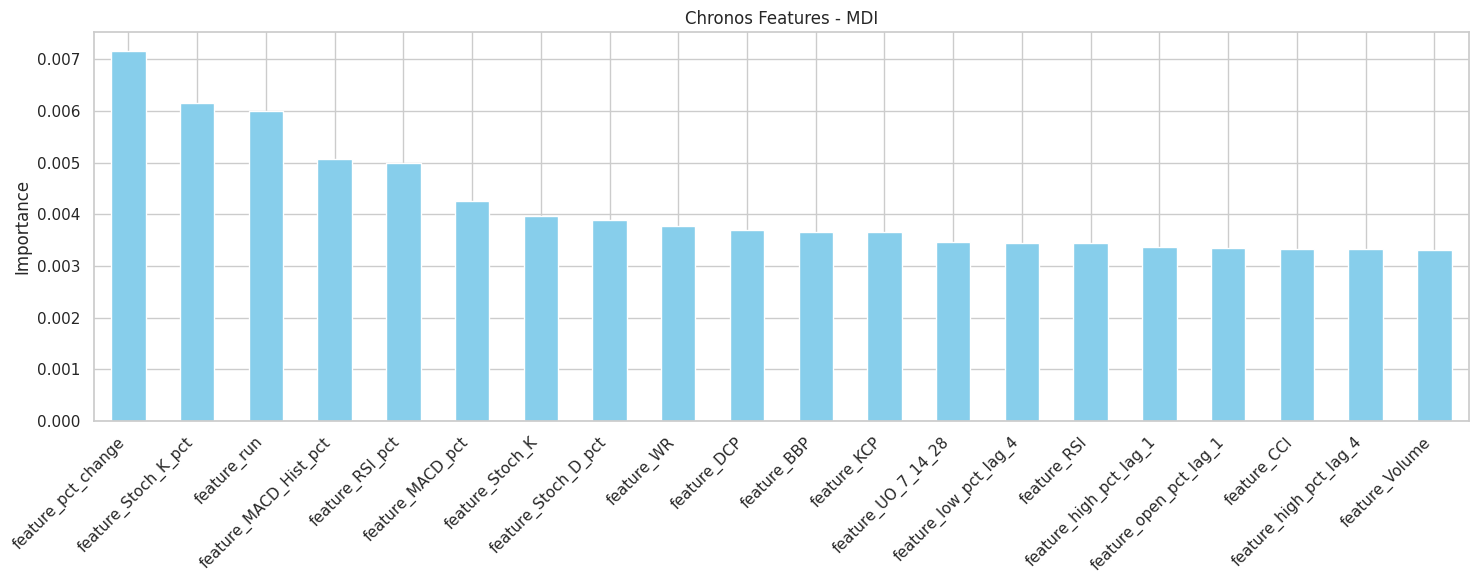

Computing MDA for Chronos Features...

>>> Function 'feature_importance_mda' executed in 168.2669 seconds


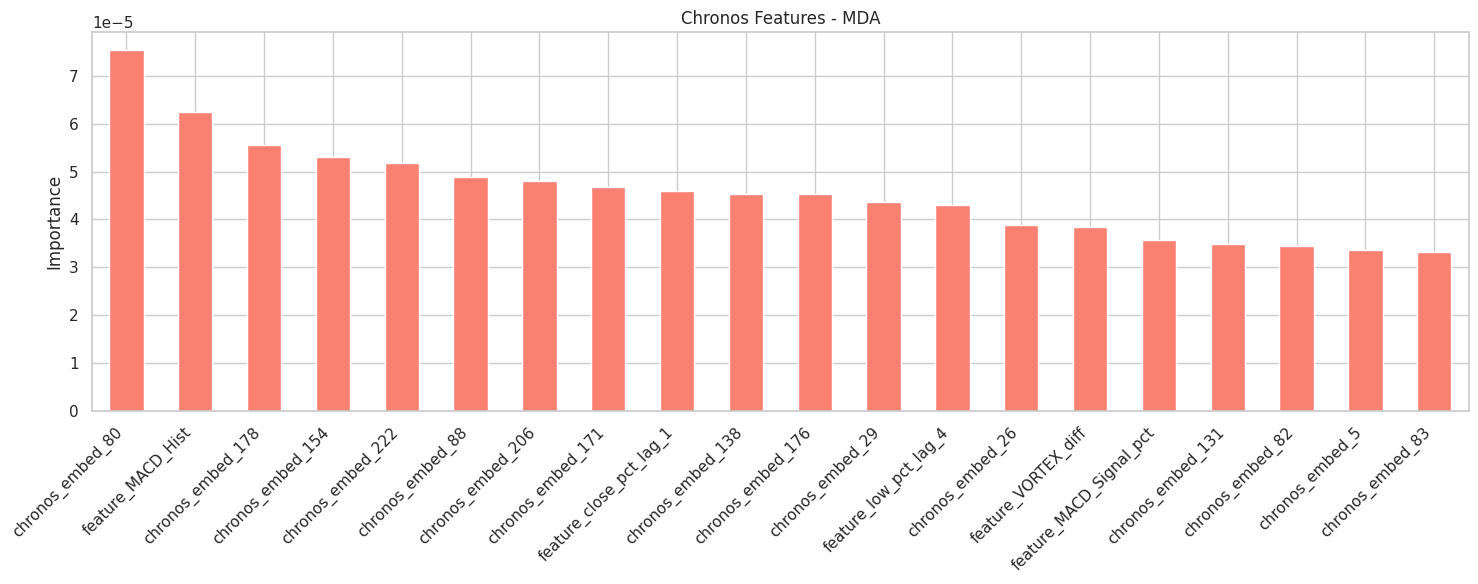

Computing SFI for Chronos Features...

>>> Function 'feature_importance_sfi' executed in 1459.6712 seconds


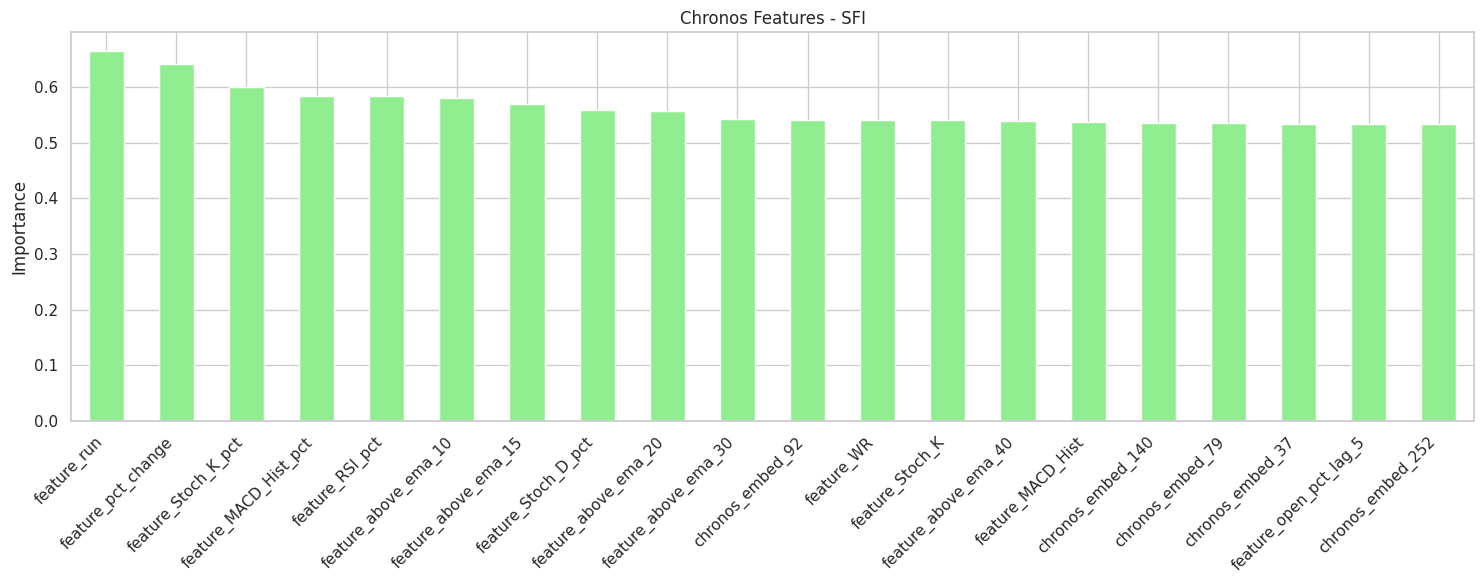


Computing Weighted Kendall's Tau Correlation Matrix for: ['MDI', 'MDA', 'SFI']


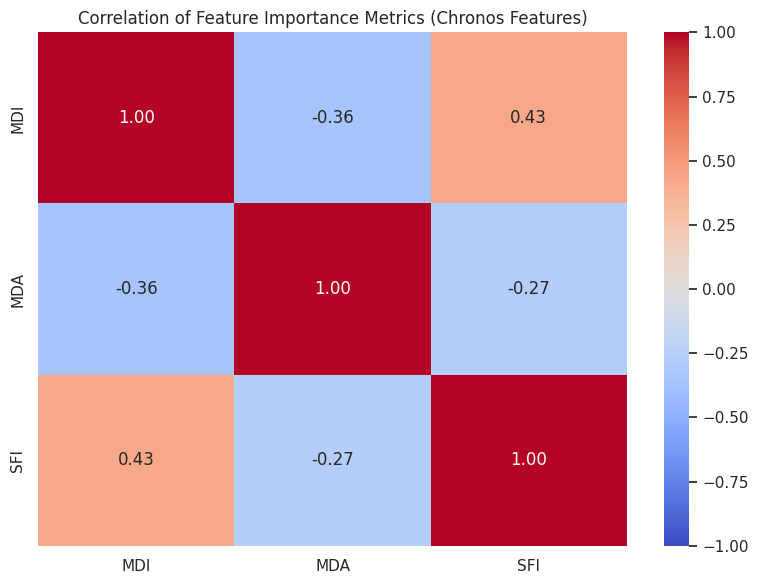

In [26]:
# ## 5. Chronos Feature Importance Analysis

try:
    # --- Configuration for Chronos Pipeline ---
    chronos_config = {
        "volume_threshold": 50000,
        "tau": 0.7,
        "n_splits": 3,
        "pct_embargo": 0.01,
        "use_pca": False,
        "chronos_model_name": "amazon/chronos-t5-tiny",
        "chronos_window_size": 128,
        "chronos_stride": 1,
    }

    print("\n--- Running Chronos Feature Pipeline ---")
    chronos_pipeline = ChronosFeaturePipeline(chronos_config)

    # Manually execute pipeline steps to get features, labels, and weights
    print("Step 1: Data Structuring...")
    bars = chronos_pipeline.step_1_data_structuring(raw_tick_data)

    print("Step 2: Generating Chronos + Tabular Features...")
    chronos_features_raw = chronos_pipeline.step_2_feature_engineering(bars)

    print("Step 3: Labeling and Weighting...")
    labels_series, chronos_sample_weights_raw, t1_series_raw = chronos_pipeline.step_3_labeling_and_weighting(bars)
    
    # Align all data before analysis
    common_index = chronos_features_raw.index.intersection(labels_series.index).intersection(chronos_sample_weights_raw.index)
    
    features_aligned = chronos_features_raw.loc[common_index]
    labels_aligned = labels_series.loc[common_index]
    weights_aligned = chronos_sample_weights_raw.loc[common_index]
    t1_aligned = t1_series_raw.loc[common_index]

    # Define CV for feature importance
    chronos_cv = PurgedKFold(
        n_splits=chronos_config["n_splits"],
        t1=t1_aligned,
        pct_embargo=chronos_config["pct_embargo"],
    )
    
    # Run the analysis
    plot_chronos_features(
        features_aligned, 
        labels_aligned, # Use the binary label series directly
        chronos_cv, 
        weights_aligned, 
        t1_aligned, 
        model_params
    )

except ImportError as e:
    print(f"\nCould not run Chronos analysis due to missing libraries: {e}")
    print("Please ensure 'torch' and 'chronos-ts' are installed.")
except Exception as e:
    print(f"\nAn error occurred during the Chronos feature analysis: {e}")